In [3]:
# 1. Instalación de librerías necesarias
!pip install numpy matplotlib imageio


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os


🚀 Iniciando Visión Estéreo y Mapa de Profundidad...

🔍 Buscando esquinas en pares estéreo...
⚙️ Calibrando sistema estéreo...
🗺️ Calculando Mapa de Profundidad...
🧊 Proyectando Realidad Aumentada...


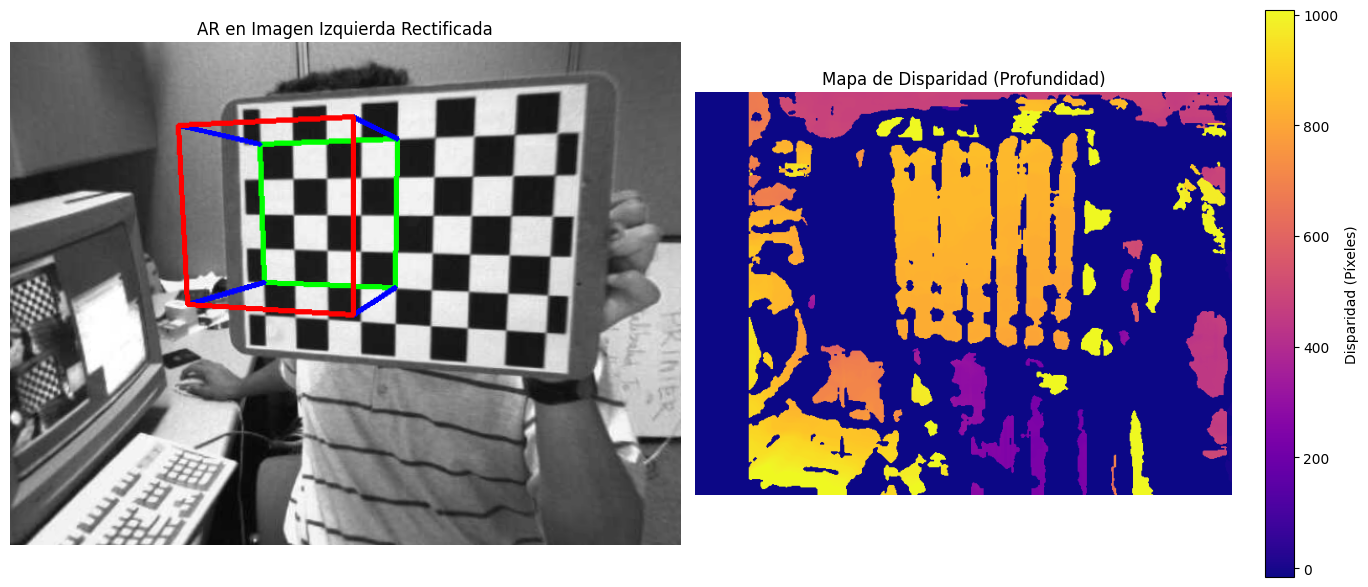

✅ Proceso completado.


In [7]:
print("🚀 Iniciando Visión Estéreo y Mapa de Profundidad...\n")

# 1. DESCARGAR IMÁGENES ESTÉREO DE PRUEBA
os.makedirs("stereo_calib", exist_ok=True)
base_url_left = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left0{}.jpg"
base_url_right = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/right0{}.jpg"

img_pairs = []
for i in range(1, 6): # Descargamos 5 pares
    img_l = f"stereo_calib/left0{i}.jpg"
    img_r = f"stereo_calib/right0{i}.jpg"
    if not os.path.exists(img_l): urllib.request.urlretrieve(base_url_left.format(i), img_l)
    if not os.path.exists(img_r): urllib.request.urlretrieve(base_url_right.format(i), img_r)
    img_pairs.append((img_l, img_r))

# 2. PREPARAR PUNTOS DEL TABLERO (9x6)
CHECKERBOARD = (9, 6)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

objpoints = [] # Puntos 3D en el mundo real
imgpoints_l = [] # Puntos 2D en cámara izquierda
imgpoints_r = [] # Puntos 2D en cámara derecha

# 3. ENCONTRAR ESQUINAS EN AMBAS CÁMARAS
print("🔍 Buscando esquinas en pares estéreo...")
img_shape = None
for left_file, right_file in img_pairs:
    imgL = cv2.imread(left_file, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(right_file, cv2.IMREAD_GRAYSCALE)
    if img_shape is None: img_shape = imgL.shape[::-1]

    retL, cornersL = cv2.findChessboardCorners(imgL, CHECKERBOARD, None)
    retR, cornersR = cv2.findChessboardCorners(imgR, CHECKERBOARD, None)

    if retL and retR:
        objpoints.append(objp)
        imgpoints_l.append(cv2.cornerSubPix(imgL, cornersL, (11,11), (-1,-1), criteria))
        imgpoints_r.append(cv2.cornerSubPix(imgR, cornersR, (11,11), (-1,-1), criteria))

# 4. CALIBRACIÓN ESTÉREO
print("⚙️ Calibrando sistema estéreo...")
# Calibramos cámaras individuales primero (recomendado para mayor precisión)
retL, mtxL, distL, _, _ = cv2.calibrateCamera(objpoints, imgpoints_l, img_shape, None, None)
retR, mtxR, distR, _, _ = cv2.calibrateCamera(objpoints, imgpoints_r, img_shape, None, None)

# Calibración conjunta (obtiene Rotación y Traslación ENTRE las dos cámaras)
flags = cv2.CALIB_FIX_INTRINSIC
retS, mtxL, distL, mtxR, distR, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_l, imgpoints_r,
    mtxL, distL, mtxR, distR, img_shape, criteria=criteria, flags=flags)

# Rectificación Estéreo (Alinear las imágenes horizontalmente)
RL, RR, PL, PR, Q, _, _ = cv2.stereoRectify(mtxL, distL, mtxR, distR, img_shape, R, T)

mapL1, mapL2 = cv2.initUndistortRectifyMap(mtxL, distL, RL, PL, img_shape, cv2.CV_16SC2)
mapR1, mapR2 = cv2.initUndistortRectifyMap(mtxR, distR, RR, PR, img_shape, cv2.CV_16SC2)

# 5. CÁLCULO DEL MAPA DE PROFUNDIDAD (DISPARIDAD)
print("🗺️ Calculando Mapa de Profundidad...")
# Cargamos el primer par para la prueba
imgL_color = cv2.imread(img_pairs[0][0])
imgL_gray = cv2.cvtColor(imgL_color, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.imread(img_pairs[0][1], cv2.IMREAD_GRAYSCALE)

# Aplicar rectificación a las imágenes
rectifiedL = cv2.remap(imgL_gray, mapL1, mapL2, cv2.INTER_LINEAR)
rectifiedR = cv2.remap(imgR_gray, mapR1, mapR2, cv2.INTER_LINEAR)

# Algoritmo SGBM (Semi-Global Block Matching)
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=64, # Debe ser divisible por 16
    blockSize=15,
    P1=8 * 3 * 15**2,
    P2=32 * 3 * 15**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)
disparity = stereo.compute(rectifiedL, rectifiedR)

# 6. AR: DIBUJAR CUBO USANDO PARÁMETROS RECTIFICADOS
print("🧊 Proyectando Realidad Aumentada...")
# Necesitamos la pose del tablero en la cámara izquierda rectificada
ret, corners_rect = cv2.findChessboardCorners(rectifiedL, CHECKERBOARD, None)
_, rvec, tvec = cv2.solvePnP(objp, corners_rect, PL[:, :3], None)

# Definir un cubo 3D grande
axis = np.float32([[0,0,0], [0,4,0], [4,4,0], [4,0,0],
                   [0,0,-4],[0,4,-4],[4,4,-4],[4,0,-4]])

imgpts, _ = cv2.projectPoints(axis, rvec, tvec, PL[:, :3], None)
imgpts = np.int32(imgpts).reshape(-1, 2)

# Dibujar el cubo sobre la imagen a color (también rectificada)
imgL_rect_color = cv2.remap(imgL_color, mapL1, mapL2, cv2.INTER_LINEAR)
cv2.drawContours(imgL_rect_color, [imgpts[:4]], -1, (0,255,0), 3) # Base verde
for i, j in zip(range(4), range(4, 8)):
    cv2.line(imgL_rect_color, tuple(imgpts[i]), tuple(imgpts[j]), (255,0,0), 3) # Pilares azules
cv2.drawContours(imgL_rect_color, [imgpts[4:]], -1, (0,0,255), 3) # Techo rojo

# 7. VISUALIZACIÓN
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("AR en Imagen Izquierda Rectificada")
plt.imshow(cv2.cvtColor(imgL_rect_color, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Mapa de Disparidad (Profundidad)")
plt.imshow(disparity, cmap='plasma')
plt.colorbar(label='Disparidad (Píxeles)')
plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Proceso completado.")

🎬 Generando animación del modelo de cámara Pinhole...
✅ GIF guardado como 'pinhole_rotation.gif'


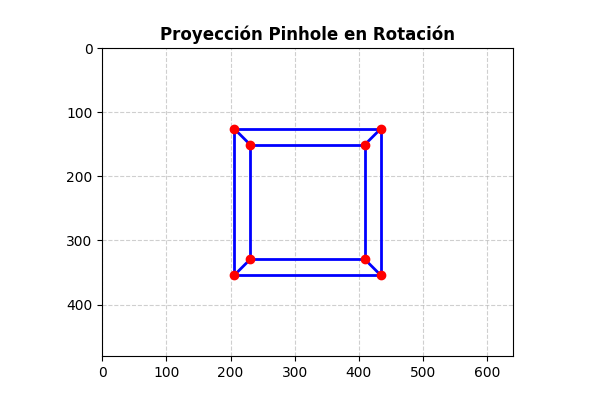

In [8]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display

print("🎬 Generando animación del modelo de cámara Pinhole...")

# 1. Definir el cubo 3D (Centrado en el origen para rotar bien)
vertices = np.array([
    [-0.5, -0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, -0.5], [-0.5, 0.5, -0.5],
    [-0.5, -0.5,  0.5], [0.5, -0.5,  0.5], [0.5, 0.5,  0.5], [-0.5, 0.5,  0.5]
], dtype=float)

edges = [
    (0,1), (1,2), (2,3), (3,0),
    (4,5), (5,6), (6,7), (7,4),
    (0,4), (1,5), (2,6), (3,7)
]

# 2. Parámetros Intrínsecos (Matriz K)
fx, fy = 800.0, 800.0
cx, cy = 320.0, 240.0
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

# Vector de traslación (Alejamos el cubo 4 unidades en Z)
t = np.array([[0.0], [0.0], [4.0]])

# 3. Función de proyección
def project_points(pts3d, K, R, t):
    pts2d = []
    for p in pts3d:
        p_cam = np.dot(R, p.reshape(3, 1)) + t
        X, Y, Z = p_cam[0,0], p_cam[1,0], p_cam[2,0]
        x_prime = (fx * X / Z) + cx
        y_prime = (fy * Y / Z) + cy
        pts2d.append([x_prime, y_prime])
    return np.array(pts2d)

# 4. Configurar la figura de Matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(0, 640)
ax.set_ylim(480, 0) # Eje Y invertido (formato imagen)
ax.set_title("Proyección Pinhole en Rotación", fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_aspect('equal')

# Crear los objetos de línea vacíos que actualizaremos en cada frame
lines = [ax.plot([], [], 'b-', linewidth=2)[0] for _ in edges]
points, = ax.plot([], [], 'ro')

# 5. Función de actualización para la animación
def update(frame):
    # Calcular ángulo de rotación (frame va de 0 a 360)
    theta = np.radians(frame)

    # Matriz de rotación sobre el eje Y
    R = np.array([
        [np.cos(theta),  0, np.sin(theta)],
        [0,              1,             0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])

    # Proyectar los puntos
    projected = project_points(vertices, K, R, t)

    # Actualizar las líneas del cubo
    for line, edge in zip(lines, edges):
        p1, p2 = projected[edge[0]], projected[edge[1]]
        line.set_data([p1[0], p2[0]], [p1[1], p2[1]])

    # Actualizar los vértices (puntos rojos)
    points.set_data(projected[:, 0], projected[:, 1])
    return lines + [points]

# 6. Generar y guardar el GIF
frames_totales = 60 # Cantidad de cuadros (60 frames para 360 grados = saltos de 6 grados)
angulos = np.linspace(0, 360, frames_totales)

ani = FuncAnimation(fig, update, frames=angulos, blit=True)

gif_filename = "pinhole_rotation.gif"
ani.save(gif_filename, writer=PillowWriter(fps=15))
plt.close(fig) # Cerramos la figura estática para no ensuciar el notebook

print(f"✅ GIF guardado como '{gif_filename}'")

# 7. Mostrar el GIF directamente en Colab
display(Image(filename=gif_filename))